In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
import re
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings

In [2]:
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 12, 8

In [3]:
def show_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def data_viz(df, cols, target = None, plot_type = 'bar'):
    col_length = len(cols)
    
    if(plot_type == 'hist'):
        col_prop = round(col_length/2)
        fig, ax = plt.subplots(col_prop, 2, figsize=(20, 6 * col_prop))
    else:
        col_prop = round(col_length/2)
        fig, ax = plt.subplots(col_prop, 2, figsize=(20, 7 * col_prop))
    
    if(plot_type=='bar_target'):
        for variable, subplot in zip(cols, ax.flatten()):
            ct = pd.crosstab(df[variable], df[target])
            ct.plot.bar(stacked=True, ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(15)
    elif(plot_type == 'bar'):
        for variable, subplot in zip(cols, ax.flatten()):
            sns.countplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'box'):       
        for variable, subplot in zip(cols, ax.flatten()):
            sorted_vals = df.groupby([variable])[target].mean().sort_values()
            sns.boxplot(x=variable, y=target, data=df, ax=subplot, order=list(sorted_vals.index))
            for label in subplot.get_xticklabels():
                label.set_rotation(30)
    elif(plot_type == 'hist'):
        for variable, subplot in zip(cols, ax.flatten()):
            df[variable].fillna(df[variable].mean(), inplace=True)
            sns.distplot(df[variable], ax=subplot)
            for label in subplot.get_xticklabels():
                label.set_rotation(15)

In [4]:
%%time
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
submission = pd.read_csv('input/sample_submission.csv')

CPU times: user 264 ms, sys: 51.8 ms, total: 316 ms
Wall time: 316 ms


In [5]:
train.shape, test.shape, submission.shape

((131662, 14), (87395, 13), (87395, 2))

In [6]:
show_all(train.head())

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [7]:
show_all(test.head())

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,A,10.0,2.57438,A,B,3.68000,2,NaN,46,63,Male
1,T0005689462,32.15,B,10.0,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,T0005689463,10.38,C,4.0,2.70530,A,D,4.50500,0,NaN,47,74,Male
3,T0005689466,14.94,NaN,6.0,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,T0005689468,32.03,B,7.0,2.81598,A,K,4.60125,3,96.0,44,56,Male


In [8]:
show_all(submission.head())

,Trip_ID,Surge_Pricing_Type
0,T0005689459,2
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [10]:
show_all(train.iloc[:,1:].describe())

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [11]:
for df in (train, test):
    missing_stats = df.isnull().mean()
    print(round(100 * missing_stats[missing_stats != 0], 2),'\n')

Type_of_Cab                    15.35
Customer_Since_Months           4.50
Life_Style_Index               15.34
Confidence_Life_Style_Index    15.34
Var1                           53.95
dtype: float64 

Type_of_Cab                    15.06
Customer_Since_Months           4.54
Life_Style_Index               15.25
Confidence_Life_Style_Index    15.25
Var1                           53.54
dtype: float64 



In [12]:
test['Surge_Pricing_Type'] = -1

In [13]:
full_data = train.append(test)
full_data.shape

(219057, 14)

## Exploratory Analysis

In [14]:
train.columns

Index(['Trip_ID', 'Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months',
       'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Gender', 'Surge_Pricing_Type'],
      dtype='object')

In [15]:
id_col = ['Trip_ID']
cat_cols = train.select_dtypes(include=['object']).columns.tolist()[1:]
target_col = 'Surge_Pricing_Type'

In [16]:
for col in full_data.columns:
    print(f"{col}: {full_data[col].nunique()}")

Trip_ID: 219057
Trip_Distance: 10594
Type_of_Cab: 5
Customer_Since_Months: 11
Life_Style_Index: 69677
Confidence_Life_Style_Index: 3
Destination_Type: 14
Customer_Rating: 3976
Cancellation_Last_1Month: 9
Var1: 130
Var2: 61
Var3: 102
Gender: 2
Surge_Pricing_Type: 4


In [17]:
train[target_col].value_counts(normalize=True)

2    0.430861
3    0.362443
1    0.206696
Name: Surge_Pricing_Type, dtype: float64

In [18]:
for col in cat_cols:
    print(f"{col}:\n{train[col].value_counts()}\n")

Type_of_Cab:
B    31136
C    28122
A    21569
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

Confidence_Life_Style_Index:
B    40355
C    35967
A    35147
Name: Confidence_Life_Style_Index, dtype: int64

Destination_Type:
A    77597
B    29555
C     7484
D     6588
E     2717
F     1950
G     1489
H     1260
I      813
J      695
K      680
L      643
N       98
M       93
Name: Destination_Type, dtype: int64

Gender:
Male      93900
Female    37762
Name: Gender, dtype: int64



In [19]:
cat_cols

['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type', 'Gender']

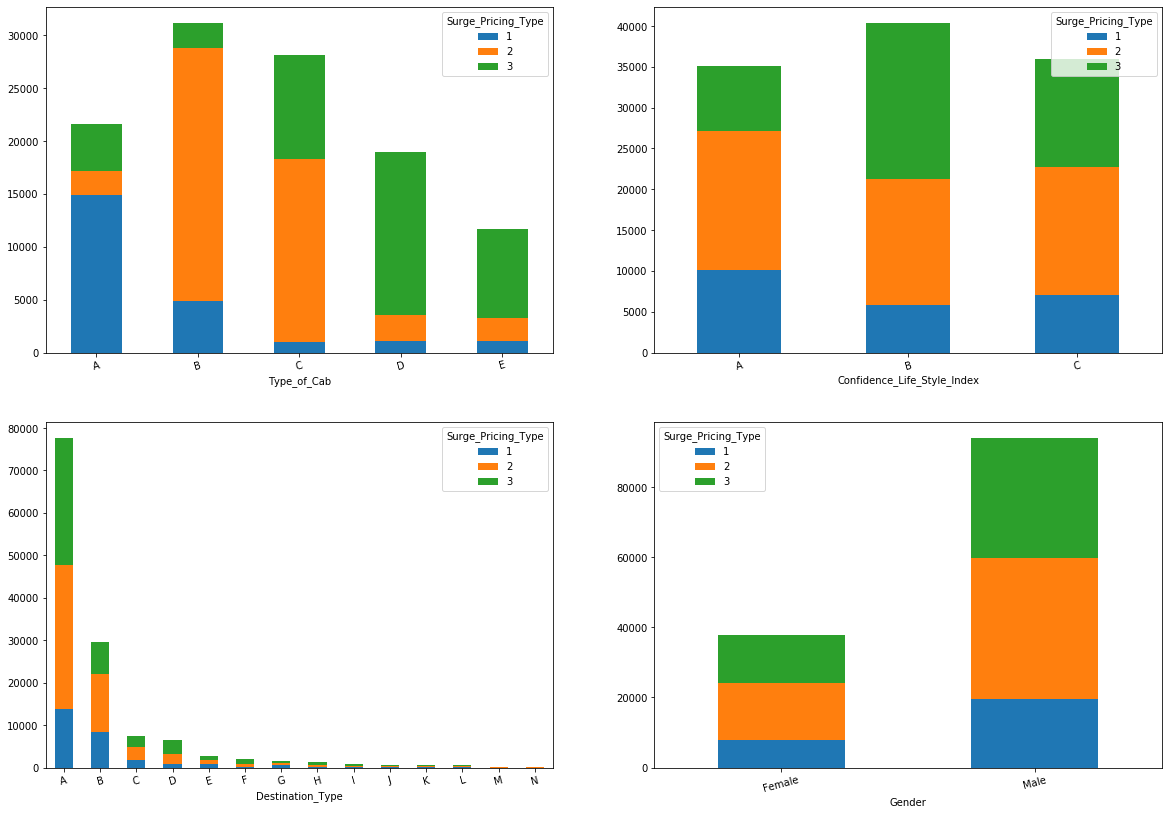

In [20]:
data_viz(train, cols = cat_cols, target='Surge_Pricing_Type', plot_type = 'bar_target')

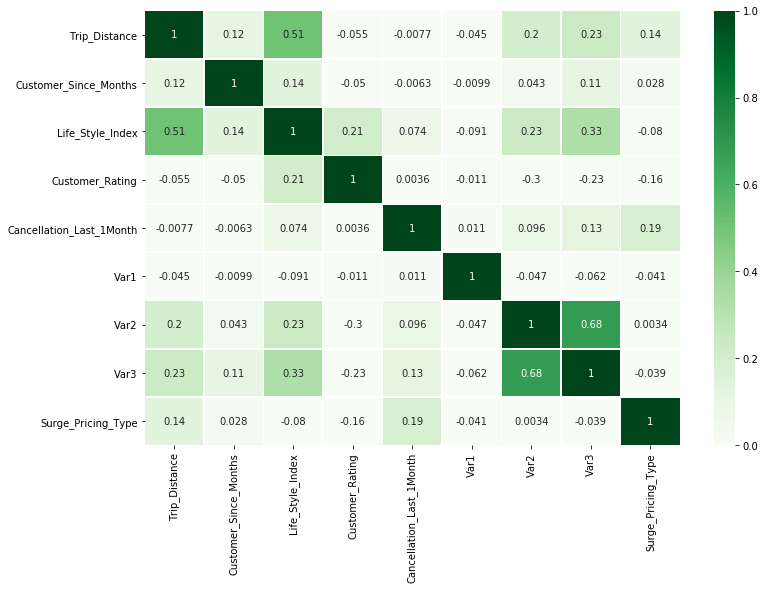

In [21]:
sns.heatmap(train.corr(), vmin=0, vmax=1, cmap="Greens", linewidths=0.5, annot=True)

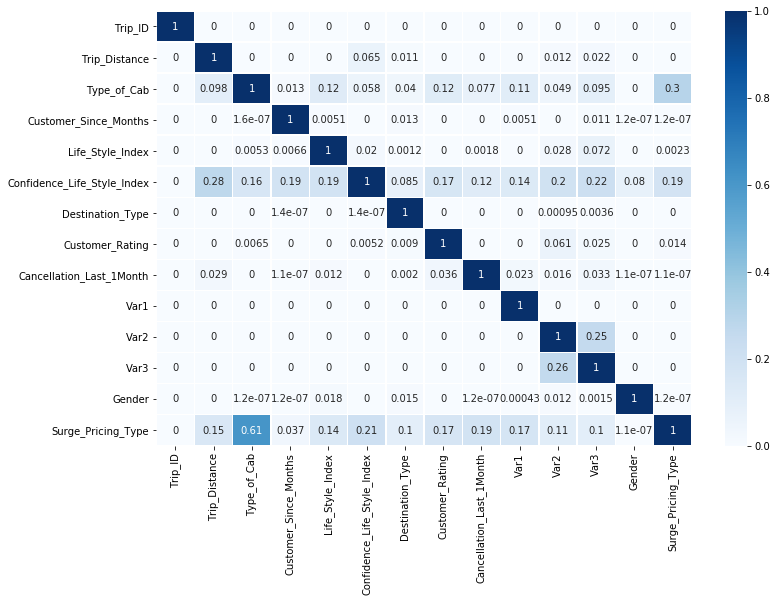

In [22]:
sns.heatmap(pps.matrix(train), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## Feature Engineering

In [23]:
show_all(full_data.head(5))

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [24]:
full_data['Var3_Var2_Diff'] = full_data['Var3'] - full_data['Var2']

In [25]:
full_data['distance_cab_change'] = full_data['Trip_Distance'] - full_data.groupby(['Type_of_Cab'])['Trip_Distance'].transform('mean')
full_data['distance_age_change'] = full_data['Trip_Distance'] - full_data.groupby(['Customer_Since_Months'])['Trip_Distance'].transform('mean')
full_data['distance_CLI_change'] = full_data['Trip_Distance'] - full_data.groupby(['Confidence_Life_Style_Index'])['Trip_Distance'].transform('mean')

In [27]:
missing_stats = full_data.isnull().mean()
print(round(100 * missing_stats[missing_stats != 0], 2),'\n')

Type_of_Cab                    15.23
Customer_Since_Months           4.51
Life_Style_Index               15.30
Confidence_Life_Style_Index    15.30
Var1                           53.78
distance_cab_change            15.23
distance_age_change             4.51
distance_CLI_change            15.30
dtype: float64 



## Modeling

In [28]:
import sys
sys.path.append('ml_modules/')

In [29]:
from custom_estimator import Estimator
from encoding import FreqeuncyEncoding
from lightgbm import LGBMClassifier
import category_encoders as enc
from sklearn.metrics import accuracy_score, log_loss
from sklearn import model_selection

Using TensorFlow backend.


In [30]:
train_data = full_data[full_data[target_col] != -1]
test_data = full_data[full_data[target_col] == -1]

In [31]:
categorical_cols = cat_cols

In [32]:
fE = FreqeuncyEncoding(categorical_columns=categorical_cols, return_df=True)
train_data = fE.fit_transform(train_data)
test_data = fE.transform(test_data)

In [33]:
# Target Encoding
X = train_data[categorical_cols]
y = train_data[target_col].values

enc_train = np.zeros(X.shape)
smoothing = 0.3

Folds = model_selection.KFold(n_splits=5, random_state=2020, shuffle=True)

for train_idx, valid_idx in Folds.split(X):
    encoder = enc.TargetEncoder(cols=categorical_cols, smoothing=smoothing)

    encoder.fit(X.iloc[train_idx], y[train_idx])
    enc_train[valid_idx, :] = encoder.transform(X.iloc[valid_idx], y[valid_idx])

encoder.fit(X, y)
enc_test = encoder.transform(test_data[categorical_cols]).values

for idx, col in enumerate(categorical_cols):
    col = 'tE_' + col 
    train_data[col] = enc_train[:,idx]
    test_data[col] = enc_test[:, idx]

In [34]:
drop_cols = [target_col] + id_col
y = train_data[target_col]

train_data.drop(columns=drop_cols, axis=1, inplace=True)
test_data.drop(columns=drop_cols, axis=1, inplace=True)

In [35]:
train_data = train_data.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(-999)
test_data = test_data.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(-999)

In [36]:
for df in (train_data, test_data):
    missing_stats = df.isnull().mean()
    print(missing_stats[missing_stats != 0])

Series([], dtype: float64)
Series([], dtype: float64)


In [37]:
train_data.shape, test_data.shape

((131662, 20), (87395, 20))

In [38]:
show_all(train_data.head())

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Var3_Var2_Diff,distance_cab_change,distance_age_change,distance_CLI_change,tE_Type_of_Cab,tE_Confidence_Life_Style_Index,tE_Destination_Type,tE_Gender
0,6.77,0.279367,1.0,2.42769,0.315307,0.589365,3.90500,0,40.0,46,60,0.28681,14,-34.787132,-34.062459,-24.064586,1.916610,1.940553,2.209922,2.157020
1,29.47,0.279367,10.0,2.78245,0.362029,0.589365,3.45000,0,38.0,56,78,0.71319,22,-12.087132,-19.086778,-24.118442,1.918327,2.327087,2.208852,2.157466
2,41.58,0.000000,10.0,-999.00000,0.000000,0.020636,3.50125,2,-999.0,56,77,0.71319,21,-999.000000,-6.976778,-999.000000,2.156102,2.159919,2.002272,2.156092
3,61.56,0.252324,10.0,-999.00000,0.000000,0.589365,3.45375,0,-999.0,52,74,0.71319,22,17.932263,13.003222,-999.000000,2.311960,2.157266,2.209952,2.157343
4,54.95,0.252324,10.0,3.03453,0.362029,0.589365,3.40250,4,51.0,49,102,0.71319,53,11.322263,6.393222,1.361558,2.312009,2.324142,2.207009,2.155250


In [39]:
lgb_params = {
    'objective': 'multiclass', 
    'boosting_type': 'gbdt', 
    'n_estimators': 20000, 
    'learning_rate': 0.01,
    'num_class': 3,
    'max_depth': 6,
    'colsample_bytree': 0.70, 
    'subsample': 0.70, 
    'subsample_freq': 5,
    'n_jobs': -1,
    'metric': 'custom',
    'random_seed': 2020
    }

lgb_100 = Estimator( LGBMClassifier(**lgb_params)
                     , random_state=100
                     , eval_metric='multi_logloss'
                     , scoring_metric=accuracy_score
                     , early_stopping_rounds=200
                     , verbose=500
                    )

In [40]:
lgb_oof_100 = lgb_100.fit_transform(train_data, y.values)

Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.694601	valid's multi_logloss: 0.701033
[1000]	train's multi_logloss: 0.670649	valid's multi_logloss: 0.68899
[1500]	train's multi_logloss: 0.657146	valid's multi_logloss: 0.686755
[2000]	train's multi_logloss: 0.64579	valid's multi_logloss: 0.686257
Early stopping, best iteration is:
[2089]	train's multi_logloss: 0.64388	valid's multi_logloss: 0.686217
Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.694373	valid's multi_logloss: 0.701832
[1000]	train's multi_logloss: 0.670829	valid's multi_logloss: 0.689737
[1500]	train's multi_logloss: 0.657295	valid's multi_logloss: 0.687371
[2000]	train's multi_logloss: 0.646065	valid's multi_logloss: 0.686682
Early stopping, best iteration is:
[2170]	train's multi_logloss: 0.642546	valid's multi_logloss: 0.686577
Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.693396	v

In [41]:
lgb_100.avg_cv_score

0.7063768988382525

In [42]:
lgb_200 = Estimator(LGBMClassifier(**lgb_params)
                     , random_state=200
                     , eval_metric='multi_logloss'
                     , scoring_metric=accuracy_score
                     , early_stopping_rounds=200
                     , verbose=500
                    )

In [43]:
lgb_oof_200 = lgb_200.fit_transform(train_data, y.values)

Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.694304	valid's multi_logloss: 0.702879
[1000]	train's multi_logloss: 0.670803	valid's multi_logloss: 0.689656
[1500]	train's multi_logloss: 0.65741	valid's multi_logloss: 0.686933
[2000]	train's multi_logloss: 0.646112	valid's multi_logloss: 0.68627
Early stopping, best iteration is:
[2233]	train's multi_logloss: 0.641247	valid's multi_logloss: 0.686061
Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.693192	valid's multi_logloss: 0.706226
[1000]	train's multi_logloss: 0.669278	valid's multi_logloss: 0.694135
[1500]	train's multi_logloss: 0.655718	valid's multi_logloss: 0.691774
[2000]	train's multi_logloss: 0.644519	valid's multi_logloss: 0.691305
Early stopping, best iteration is:
[1996]	train's multi_logloss: 0.644602	valid's multi_logloss: 0.691301
Training until validation scores don't improve for 200 rounds
[500]	train's multi_logloss: 0.693426	

In [44]:
lgb_200.avg_cv_score

0.7062250437537866

In [45]:
np.mean([lgb_100.avg_cv_score, lgb_200.avg_cv_score]) #0.70630097

0.7063009712960195

In [46]:
lgb_100.feature_importances(columns=train_data.columns).head(10)

,column,feature_importance,rank
6,Customer_Rating,0.106089,1
3,Life_Style_Index,0.088023,2
0,Trip_Distance,0.086261,3
18,tE_Destination_Type,0.063687,4
8,Var1,0.063108,5
12,Var3_Var2_Diff,0.062400,6
16,tE_Type_of_Cab,0.060167,7
14,distance_age_change,0.058592,8
10,Var3,0.055955,9
15,distance_CLI_change,0.055452,10


In [47]:
lgb_pred_100 = lgb_100.transform(test_data)
lgb_pred_200 = lgb_200.transform(test_data)

In [48]:
final_sub = submission.copy()

In [49]:
final_sub[target_col] = np.argmax(np.mean([lgb_pred_100, lgb_pred_200], axis=0), axis=-1) + 1

In [50]:
final_sub.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [51]:
final_sub['Surge_Pricing_Type'].value_counts(normalize=True)

2    0.504422
3    0.340798
1    0.154780
Name: Surge_Pricing_Type, dtype: float64

In [52]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
model_name='LGB'

In [53]:
final_sub.to_csv(f"output/{model_name}_{file_timestamp}.csv", index=False)